# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/home/kira/cloned/tensorflow object detection API/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/kira/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/kira/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/kira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/kira/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/kira/anaconda3/lib/python3.6/site-packages/ipykernel/kerne

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'rlc_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')

NUM_CLASSES = 3

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [9]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

[ 0.23678647  0.28582782  0.31054932  0.46136171]
1
0.604744


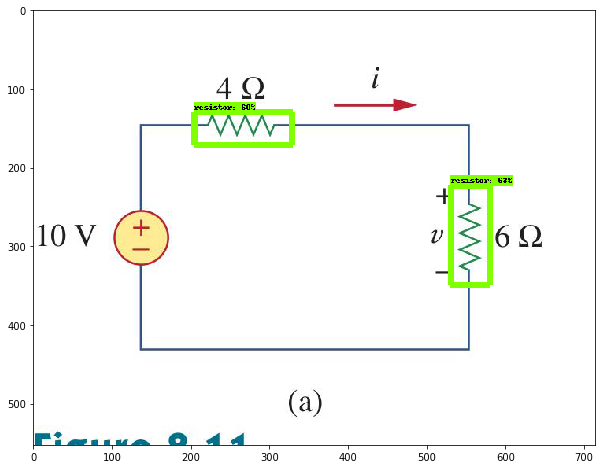

In [11]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
 
print(output_dict['detection_boxes'][1])
print(output_dict['detection_classes'][1])
print(output_dict['detection_scores'][1])

In [10]:
#! /usr/bin/env python
#  -*- coding: utf-8 -*-
#
# GUI module generated by PAGE version 4.21
#  in conjunction with Tcl version 8.6
#    Mar 18, 2019 12:46:54 AM EAT  platform: Linux

import sys

try:
    import Tkinter as tk
except ImportError:
    import tkinter as tk

try:
    import ttk
    py3 = False
except ImportError:
    import tkinter.ttk as ttk
    py3 = True

import ecda_support
import os.path
from tkinter import filedialog
from PIL import Image, ImageTk

ckt_image = None
box_coord = None
box_class = None

def vp_start_gui():
    '''Starting point when module is the main routine.'''
    global val, w, root
    global prog_location
    prog_call = sys.argv[0]
    print ('prog_call = {}'.format(prog_call))
    prog_location = os.path.split(prog_call)[0]
    print ('prog_location = {}'.format(prog_location))
    sys.stdout.flush()
    root = tk.Tk()
    top = ecda_gui (root)
    ecda_support.init(root, top)
    root.mainloop()

w = None
def create_ecda_gui(root, *args, **kwargs):
    '''Starting point when module is imported by another program.'''
    global w, w_win, rt
    global prog_location
    prog_call = sys.argv[0]
    print ('prog_call = {}'.format(prog_call))
    prog_location = os.path.split(prog_call)[0]
    print ('prog_location = {}'.format(prog_location))
    rt = root
    w = tk.Toplevel (root)
    top = ecda_gui (w)
    ecda_support.init(w, top, *args, **kwargs)
    return (w, top)

def destroy_ecda_gui():
    global w
    w.destroy()
    w = None

class ecda_gui:
    
    def __init__(self, top=None):
        '''This class configures and populates the toplevel window.
           top is the toplevel containing window.'''
        _bgcolor = '#d9d9d9'  # X11 color: 'gray85'
        _fgcolor = '#000000'  # X11 color: 'black'
        _compcolor = '#d9d9d9' # X11 color: 'gray85'
        _ana1color = '#d9d9d9' # X11 color: 'gray85'
        _ana2color = '#ececec' # Closest X11 color: 'gray92'
        font9 = "-family {gothic} -size 9"
        self.style = ttk.Style()
        if sys.platform == "win32":
            self.style.theme_use('winnative')
        self.style.configure('.',background=_bgcolor)
        self.style.configure('.',foreground=_fgcolor)
        self.style.configure('.',font="TkDefaultFont")
        self.style.map('.',background=
            [('selected', _compcolor), ('active',_ana2color)])

        top.geometry("934x504+284+162")
        top.title("Schematic Detector")
        top.configure(background="#1f2b54")

        self.schematic_img_frame = tk.LabelFrame(top)
        self.schematic_img_frame.place(relx=0.021, rely=0.02, relheight=0.843
                , relwidth=0.642)
        self.schematic_img_frame.configure(relief='groove')
        self.schematic_img_frame.configure(font=font9)
        self.schematic_img_frame.configure(text='''Schematic''')
        self.schematic_img_frame.configure(width=600)

        self.image_lbl = tk.Label(self.schematic_img_frame)
        self.image_lbl.place(relx=0.017, rely=0.071, height=375, width=569
                , bordermode='ignore')
        self.image_lbl.configure(width=569)

        self.browse_btn = tk.Button(top)
        self.browse_btn.place(relx=0.118, rely=0.913, height=25, width=140)
        self.browse_btn.configure(text='''Browse''')
        self.browse_btn.configure(command=lambda: open_image())
        self.browse_btn.configure(width=140)

        self.process_btn = tk.Button(top)
        self.process_btn.place(relx=0.332, rely=0.913, height=25, width=110)
        self.process_btn.configure(text='''Process''')
        self.process_btn.configure(command=lambda: process_ckt())
        self.process_btn.configure(width=110)

        self.btn_sprtr = ttk.Separator(top)
        self.btn_sprtr.place(relx=0.3, rely=0.893, relheight=0.079)
        self.btn_sprtr.configure(orient="vertical")

        self.frame_sprtr = ttk.Separator(top)
        self.frame_sprtr.place(relx=0.707, rely=0.06, relheight=0.754)
        self.frame_sprtr.configure(orient="vertical")

        self.component_detail = tk.Message(top)
        self.component_detail.place(relx=0.728, rely=0.079, relheight=0.688
                , relwidth=0.247)
        self.component_detail.configure(text='''Message''')
        self.component_detail.configure(width=231)
        
        def open_image():
            global ckt_image
            ckt_image = filedialog.askopenfilename(initialdir = "/home/kira/cloned/tensorflow object detection API/models/research/object_detection/test_images", title = "Select circuit image", filetypes= (("jpeg", "*.jpg"), ("All files", "*.*")))
            unresized = Image.open(ckt_image)
            image_path = ImageTk.PhotoImage(unresized.resize((560,370),Image.ANTIALIAS))
            self.image_lbl.configure(image=image_path) 
            self.image_lbl.pack(self, fill= BOTH, expand=1)
            self.schematic_img_frame.pack_propagate(1)
            self.schematic_img_frame.pack()
            
        def process_ckt():
            global ckt_image, box_coord, box_class
            image = Image.open(ckt_image)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            #image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            output_dict = run_inference_for_single_image(image_np, detection_graph)
            # Visualization of the results of a detection.
            _, box_class = vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                output_dict['detection_boxes'],
                output_dict['detection_classes'],
                output_dict['detection_scores'],
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=8)
            
            comp_detail_msg = ""
            for box_coordinate, component_class in box_class.items():
                comp_detail_msg += str(component_class) + "\n" + str(box_coordinate)+"\n\n"
            
            self.component_detail.configure(text=comp_detail_msg)
            self.component_detail.pack_propagate(1)
            
            unresized = Image.fromarray(image_np)
            image_path = ImageTk.PhotoImage(unresized.resize((560,370),Image.ANTIALIAS))
            self.image_lbl.configure(image=image_path) 
            self.image_lbl.pack(self, in_= self.schematic_img_frame)
            self.schematic_img_frame.pack_propagate(1)
            self.schematic_img_frame.pack(in_= top)
            self.component_detail.pack(in_= top)
            
            

if __name__ == '__main__':
    vp_start_gui()

prog_call = /home/kira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py
prog_location = /home/kira/anaconda3/lib/python3.6/site-packages


Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/kira/anaconda3/lib/python3.6/tkinter/__init__.py", line 1699, in __call__
    return self.func(*args)
  File "<ipython-input-10-c63e82eca4f6>", line 105, in <lambda>
    self.browse_btn.configure(command=lambda: open_image())
  File "<ipython-input-10-c63e82eca4f6>", line 134, in open_image
    self.image_lbl.pack(self, fill= BOTH, expand=1)
NameError: name 'BOTH' is not defined


_cnfmerge: fallback due to: 'ecda_gui' object is not iterable


Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/kira/anaconda3/lib/python3.6/tkinter/__init__.py", line 103, in _cnfmerge
    cnf.update(c)
TypeError: 'ecda_gui' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kira/anaconda3/lib/python3.6/tkinter/__init__.py", line 1699, in __call__
    return self.func(*args)
  File "<ipython-input-10-c63e82eca4f6>", line 111, in <lambda>
    self.process_btn.configure(command=lambda: process_ckt())
  File "<ipython-input-10-c63e82eca4f6>", line 169, in process_ckt
    self.image_lbl.pack(self, in_= self.schematic_img_frame)
  File "/home/kira/anaconda3/lib/python3.6/tkinter/__init__.py", line 2137, in pack_configure
    + self._options(cnf, kw))
  File "/home/kira/anaconda3/lib/python3.6/tkinter/__init__.py", line 1312, in _options
    cnf = _cnfmerge((cnf, kw))
  File "/home/kira/anaconda3/lib/python3.6/tkinter/__init__.py", l

In [14]:
box_class

defaultdict(list,
            {(0.23678646981716156,
              0.2858278155326843,
              0.3105493187904358,
              0.46136170625686646): ['resistor: 60%'],
             (0.4042844772338867,
              0.7420671582221985,
              0.6319484710693359,
              0.8116713166236877): ['resistor: 63%']})

In [11]:
#function for creating a dictionary with center coordinate and type of detected objects. (Y,X) COORDINATES ARE USED.
def obj_type_center_coord(box_class):
    temp_coord = np.array(list(box_class.keys()))
    temp_type = np.array( list(box_class.values()))
    
    obj_coord_center = np.array([(temp_coord[:,0] + (temp_coord[:,2]-temp_coord[:,0])/2),(temp_coord[:,1] + (temp_coord[:,3]-temp_coord[:,1])/2)]).T
    obj_type = np.array((list(np.char.split(temp_type.reshape((temp_type.shape[0],)), sep=':'))))[:,0]
    
    obj_dict = {}
    for key, value in zip(obj_coord_center, obj_type):
        obj_dict[tuple(key)] = value
    
    return obj_dict

In [18]:
import pytesseract
from pytesseract import Output

#function for creating a dictionary with the detected text and its bounding box center coordinate. (Y,X) COORDINATES ARE USED.
def ocr_text_center_coord(tesser_output, image_height_width):
    img_height, img_width = image_height_width
    num_boxes = len(tesser_output['level'])
    temp_coord = []
    temp_text = []
    ocr_dict={}
    
    for i in range(num_boxes):
        if text_coord['text'][i]!= "" :
            (x, y, width, height, text) = (text_coord['left'][i], text_coord['top'][i], text_coord['width'][i], text_coord['height'][i],text_coord['text'][i])
            temp_coord.append([y, x, y+height, x+width])
            temp_text.append(text)
    
    temp_coord = np.array(temp_coord)
    temp_coord_center = np.array([(temp_coord[:,0] + (temp_coord[:,2]-temp_coord[:,0])/2)/img_height, (temp_coord[:,1] + (temp_coord[:,3]-temp_coord[:,1])/2)/img_width]).T
    for key, value in zip(temp_coord_center, temp_text):
        ocr_dict[tuple(key)] = value
        
    return ocr_dict

In [12]:
class electrical_elmnt():
    
    #make them unaccessable from outside
    
    default_start_node = 0
    default_end_node = 1
    
    def __init__(self, center_coord=None, elmnt_type=None, elmnt_value=None, elmnt_label=None, node_pair=(default_start_node, default_end_node)):
        self.center_coord = center_coord
        self.elmnt_type  = elmnt_type
        self.elmnt_value = elmnt_value
        self.elmnt_label = elmnt_label
        self.node_pair = node_pair

In [13]:
class electrical_ckt():
    
    #function to generate netlist and export the netlist to python commands which 
    #will be later used to redraw the circuit diagram using the scheme draw python package
    def export_to_schem_draw():
        pass
    
    #function to generate and export netlist of the circuit to a cir file which will be used
    #by ngspice for simulation
    def export_to_cir():
        pass
    
    #function to redraw and display the circuit diagram usng the scheme draw python package
    def draw_ckt():
        pass
    
    #function to start simulation on the circuit using ngspice
    def simulate():
        pass